## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint.csv"

## Read in data

In [2]:
def load_wifi_data(path=DATA_SOURCE):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

all_data = load_wifi_data()
print(all_data["clientCount"].sum())  # should be 3597531

3597531


In [3]:
all_data.reset_index(inplace=True)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

         time_bucket               building  clientCount
0      1620991800000      03-Science Center           34
1      1620991800000             05-TNW-BIO            1
2      1620991800000             08-BK-City            2
3      1620991800000   19-Studuitzendbureau           13
4      1620991800000                20-Aula           32
...              ...                    ...          ...
78161  1621608600000                 64-HSL           10
78162  1621608600000          66-Fellowship          126
78163  1621608600000  Katalyse Labaratorium            8
78164  1621608600000                Unknown           32
78165  1621608600000           VLL-LAB(TNO)           11

[78166 rows x 3 columns]


## Separate Test Set stratified over buildings

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

         time_bucket                           building  clientCount
11688  1621083900000                    37-Sportcentrum           15
61351  1621476000000                         36-ESP-Lab            1
55780  1621431900000                      66-Fellowship          101
26158  1621198200000                          32-OCP-IO           12
34879  1621266900000                             64-HSL           16
...              ...                                ...          ...
50892  1621393500000                            28- WNI            4
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160   1621024500000                      35-Drebbelweg            2
56082  1621434300000                          63-Simona            8
55786  1621432200000                         08-BK-City          670

[62532 rows x 3 columns]


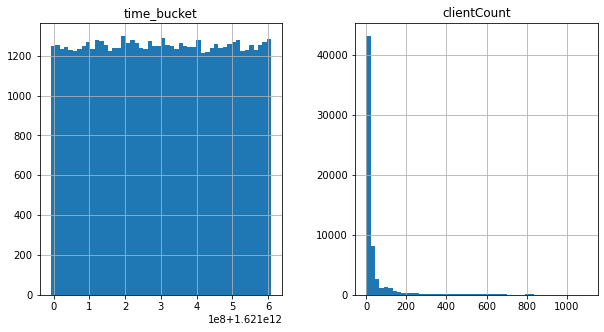

In [5]:
strat_train_set.hist(bins=50, figsize=(10,5))
plt.show()